##Импортируем нужные модули

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

##Закачиваем датасет

In [ ]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
dataset_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
dataset_dir = pathlib.Path(dataset_dir).with_suffix('')

228813984/228813984 [==============================] - 2s 0us/step


Выводим кол-во. изображений в датасете

In [ ]:
image_count = len(list(dataset_dir.glob("*/*.jpg")))
print(f"Всего изображений: {image_count}")

Всего изображений: 3670


## Создаем датасеты и кэшируем их

In [ ]:
batch_size = 32
img_width = 180
img_height = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
	dataset_dir,
	validation_split=0.2,
	subset="training",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
	dataset_dir,
	validation_split=0.2,
	subset="validation",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

# cache
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Class names: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Создаем модель, компилируем её и выводим summary

In [ ]:
# create model
num_classes = len(class_names)
model = Sequential([
	# т.к. у нас версия TF 2.6 локально
	layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

	# дальше везде одинаково
	layers.Conv2D(8, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(num_classes)
])

# compile the model
model.compile(
	optimizer='adam',
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy'])

# print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 32)        4

##Обучаем нейросеть и выводим графики точности


Epoch 1/10
92/92 [==============================] - 20s 46ms/step - loss: 1.4728 - accuracy: 0.3760 - val_loss: 1.1635 - val_accuracy: 0.5599
Epoch 2/10
92/92 [==============================] - 1s 13ms/step - loss: 1.0407 - accuracy: 0.5886 - val_loss: 0.9815 - val_accuracy: 0.6076
Epoch 3/10
92/92 [==============================] - 1s 13ms/step - loss: 0.8736 - accuracy: 0.6649 - val_loss: 0.9453 - val_accuracy: 0.6090
Epoch 4/10
92/92 [==============================] - 1s 13ms/step - loss: 0.7375 - accuracy: 0.7302 - val_loss: 0.9639 - val_accuracy: 0.6431
Epoch 5/10
92/92 [==============================] - 1s 13ms/step - loss: 0.5802 - accuracy: 0.7909 - val_loss: 0.9719 - val_accuracy: 0.6267
Epoch 6/10
92/92 [==============================] - 1s 13ms/step - loss: 0.4189 - accuracy: 0.8460 - val_loss: 1.0124 - val_accuracy: 0.6349
Epoch 7/10
92/92 [==============================] - 1s 13ms/step - loss: 0.2819 - accuracy: 0.9145 - val_loss: 1.1736 - val_accuracy: 0.6226
Epoch 8/10
9

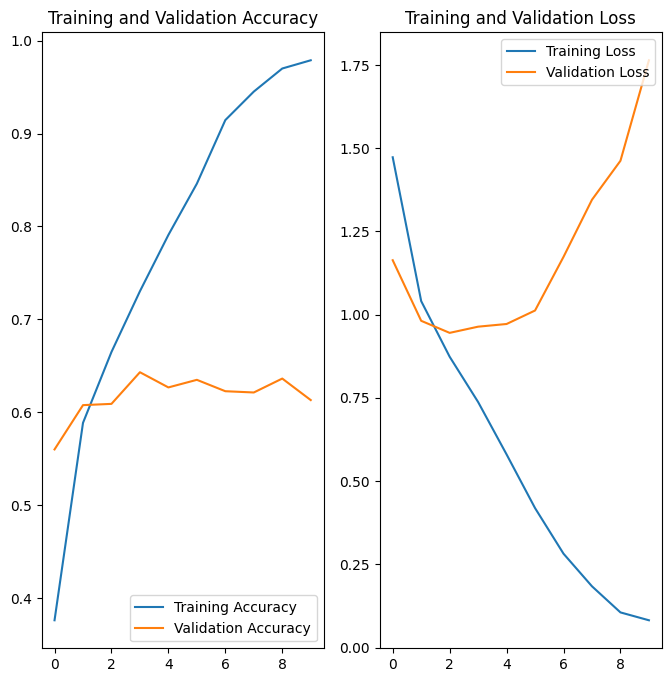

In [ ]:
# train the model
epochs = 10 # количество эпох тренировки
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs)

# visualize training and validation results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Решение проблемы переобучения.
##Добавляем аугментацию и регуляризацию (Dropout)

In [ ]:
model = Sequential([
	# т.к. у нас версия TF 2.6 локально
	layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

	# аугментация
	layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
	layers.experimental.preprocessing.RandomRotation(0.1),
	layers.experimental.preprocessing.RandomZoom(0.1),
	layers.experimental.preprocessing.RandomContrast(0.2),

	# дальше везде одинаково

	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(64, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(128, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

 	layers.Conv2D(10, 3, padding='same', activation='softmax'),
	layers.MaxPooling2D(),


	# регуляризация
	layers.Dropout(0.4),

	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(num_classes)
])

# compile the model
model.compile(
	optimizer='adam',
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy'])

# print model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_flip_5 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_5 (RandomR  (None, 180, 180, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_5 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 random_contrast_5 (RandomC  (None, 180, 180, 3)       0         
 ontrast)                                                        
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 32)     

##Повторно обучаем нейросеть с новыми слоями и увеличенным количеством эпох обучения

In [ ]:
# train the model
epochs = 40 # количество эпох тренировки
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs)

# visualize training and validation results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Epoch 1/40
92/92 [==============================] - 5s 56ms/step - loss: 0.6792 - accuracy: 0.7381 - val_loss: 0.6957 - val_accuracy: 0.7343
Epoch 2/40
92/92 [==============================] - 5s 56ms/step - loss: 0.6634 - accuracy: 0.7473 - val_loss: 0.7157 - val_accuracy: 0.7316
Epoch 3/40
92/92 [==============================] - 5s 57ms/step - loss: 0.6560 - accuracy: 0.7428 - val_loss: 0.7183 - val_accuracy: 0.7193
Epoch 4/40
92/92 [==============================] - 5s 56ms/step - loss: 0.6564 - accuracy: 0.7463 - val_loss: 0.7837 - val_accuracy: 0.6962
Epoch 5/40
92/92 [==============================] - 5s 57ms/step - loss: 0.6517 - accuracy: 0.7554 - val_loss: 0.6636 - val_accuracy: 0.7507
Epoch 6/40
92/92 [==============================] - 5s 57ms/step - loss: 0.6392 - accuracy: 0.7582 - val_loss: 0.7713 - val_accuracy: 0.7112
Epoch 7/40
92/92 [==============================] - 5s 56ms/step - loss: 0.6174 - accuracy: 0.7629 - val_loss: 0.6925 - val_accuracy: 0.7452
Epoch 8/40
92

##Делаем инференс на новом изображении

In [ ]:
# load image
sunflower_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRhmwyldi9GtJN58MSiCwRN2cNHPOkDQwntYg&s"
sunflower_path = tf.keras.utils.get_file('Wome47', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# print inference result
print("На изображении скорее всего {} ({:.2f}% вероятность)".format(
	class_names[np.argmax(score)],
	100 * np.max(score)))

# show the image itself
img.show()

1/1 [==============================] - 0s 72ms/step
На изображении скорее всего sunflowers (70.93% вероятность)


##Экспорт файла модели (скачать себе на компьютер)

In [ ]:
from google.colab import files

model_file_name = "my_flowers_model.h5"

# save model
model.save(model_file_name)

# download model
files.download(model_file_name)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>